At this point, we know how to use scikit learn to do simple and multiple regression as well as classification using k-Nearest Neighbors. We have a set of training data $\mathbf{X} \in \mathbb{R}^{(n \times d)}$ where $n$ is the number of samples and $d$ is the number of attributes/features per sample. We have a set of labels or target values $\mathbf{y} \in \mathbb{R}^{n}$ that represent the value we want to predict the model. We initialize a new, empty scikit learn model, train it using ``fit``, and, presto, we have a model that can predict the label $y$ for a new, unseen set of features. 

But how do we know this model is even good? This is where evaluation comes in. 

First, we'll discuss the concepts of generalizability and overfitting. Then, we'll go over metrics we can use to quantify how well a regressor model or classifier performs. 

# Generalizability

**Generalization** refers to an already-trained model's ability to perform well on new, unseen data. Generalization is import because we are interested in creating a model that explains the relationship between **all potential** data points, not *just* the data points in the training set. For example, we want to explain the relationship between height and weight among **all** the aliens, not just the ones that are represented in the dataset. 

Evaluating whether or not a model is general is important because all statistical models are susceptible to a problem known as **overfitting.** Overfitting occurs when when the chosen method learns a model that is specific to the training set but not the actual relationship between the independent and dependent variables. 

So, if we're going to evaluate a model we do so by seeing how well the model performs on **unseen data**. If it performs well, the model is general. If not, it is possibly overfit. Our question now is: where do we get unseen data?

# Train-Test Split

The most common approach to "getting unseen data" is to divide the data you *do* have into training and testing sets. Consider this to be an "artificial" way to generate "unseen data." Let's say you have 1000 data points, and you want to perform a train-test split of 80%/20%. What you do is randomly sample 80% of the data points you have - that would be 800 data points - and use that as your training data. The remaining 20% (200 points) will be the test data.

Using scikit-learn, we train our model **only** on the training set. Then, we ask our model to make predictions on the test set. Remember, the model did not see the test data during training. If the model predicts the test set labels well, then it is general - it works on data that it has not seen. Otherwise, there may be a problem with your approach.

## Making a Train-Test Split in Python

Let's return to problem of predicting an alien's weight from its height. I'm going to recreate the data here, using a random seed to ensure that we get the same set of numbers. 

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.ioff()

np.random.seed(3057)
heights = np.random.normal(113, 20, 1000)
noise = np.random.normal(0, 5, 1000)
weights = 25.39 + .34 * heights + noise
heights = heights.reshape(-1, 1)
weights = weights.reshape(-1, 1)

This is the same data we worked with in the Simple Linear Regression notebook. Fortunately, there is a scikit learn method that makes splitting data in to train and test sets very easy. It is called ``train_test_split`` and it is located in ``sklearn.model_selection``.

In [2]:
from sklearn.model_selection import train_test_split

The ``train_test_split`` method takes **3 arguments** and gives **4 return values**. 

The arguments are: the training data, the training labels, and the proportion of the data that should be allocated to the test set.

The return values are: the training set data, the test set data, the training set labels, the test set labels. 

I'm going to make a train-test split with the test set being 20% of the original data. Using tuple assignment, I can easily capture all the return values of the function in variables that have intuitive names.

In [3]:
heights_train, heights_test, weights_train, weights_test = train_test_split(heights, weights, test_size=0.2)

In [4]:
print(heights_train.shape)
print(heights_test.shape)

(800, 1)
(200, 1)


With one line of code, we've split our data. The training set has 800 samples, the test set has 200 samples. Let's go ahead and make and train our model - using *only* the training data. 

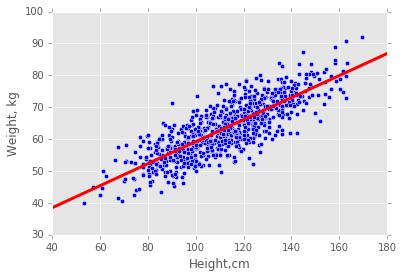

In [5]:
lr = LinearRegression()
lr.fit(heights_train, weights_train)

fig, ax = plt.subplots()
ax.set_xlabel("Height,cm")
ax.set_ylabel("Weight, kg")
ax.scatter(heights_train, weights_train)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [lr.predict(xmin)[0][0], lr.predict(xmax)[0][0]], linewidth=3, color="red")
ax.set_xlim([xmin, xmax])
fig

This plot may look similar to the one in the first notebook, but there are only 800 data points here, not 1000. 200 have been set aside in the test set. The red line - the model - is only trained on the 800 data points in the training set. 

The next step is to see how well the model performs on the unseen data, stored in ``heights_test`` and ``weights_test``. This will involve us asking the model to predict the weights given the heights in ``heights_test`` and compare the predicted weights to the actual weights in ``weights_test``. Let's go ahead and obtain those predictions using the function ``predict``.

In [6]:
weights_predicted = lr.predict(heights_test)
print(weights_predicted[:5])
print('*'*50)
print(weights_test[:5])

[[ 65.22902827]
 [ 64.75584824]
 [ 70.31820014]
 [ 59.34266733]
 [ 65.39356362]]
**************************************************
[[ 74.37035378]
 [ 66.80354693]
 [ 68.55201111]
 [ 67.91885942]
 [ 65.92296377]]


So we can see that for the first datapoint in the test data, the model predicts that the first alien will weight 65.23 kg, but in reality, the first alien weights 74.37. The model predicted the second weights 64.76, but in reality the second weighs 66.80. On one hand, there are some differences; on the other hand, the predictions aren't too shabby. How can we quantify this difference?

# Mean Squared Error

The difference between the value predicted by the model and the actual value is known as the *residual* or *error*. A good model should have small residuals - in other words, its predictions should be close to reality. 

To measure this for a specific model we have a measure called the *mean squared error*, or MSE. For each data point in the test set, take the error (the difference between prediction and reality) and square it. Then, get the average across all data points. This provides a single number - a single score, if you will - representing the quality of the model. Lower is better.

Why square the error? There are many reasons, and this is a thoroughly researched question. But here's the short answer: note that when a point is above the line, is error is positive, when it's below it, the error is negative. But we don't care if the point is above or below the line, we care how *far* it is from the line. By squaring each number, we remove the error from the residuals. 

Let's take a look at the mean squared error of this model on the unseen test set data. 

As usual, scikit learn very handily has a function that calculates this for us. 

In [7]:
from sklearn.metrics import mean_squared_error

The mean squared error takes two arguments. First, provide the true values for each data point: in our case, the true weights in the dataset. Then, provide the *predicted* values for each datapoint: in our case, the weights predicted by the model when we input the test heights. 

In [8]:
MSE = mean_squared_error(weights_test, weights_predicted)
MSE

22.109118875692197

In [9]:
np.sqrt(MSE)

4.7020334830466908

The mean squared error on the test data is 22.11. That means that on average, the predicted weights were $\sqrt{22.11} = 4.70$ kg away from the actual value. Not bad! Remember, this is on the test data, so the model didn't see this data during training.

# R Squared

So, the MSE on the test data is 22.11. So what? Is that good or bad? We have one number in a vacuum, it's not very helpful. It would be more helpful if we could compare 22.11 to something else. It would be helpful if there were some sort of *baseline* against which we can say our model performed "better" or "worse." What's a good baseline?

In regression, the most commonly used baseline is simply the average value of the dependent variable. 

Let's imagine a really naive, unsophisticated model that simply outputs the *average value of all the weights* every time, no matter what height you give it. Tall alien? Guess the average weight of all the aliens. Short alien? Guess the average weight. This is a naive model, but it's not an illogical one: if the weights are normally distributed, then most of the weights will be near the average. Here's how such a "model" would look: 

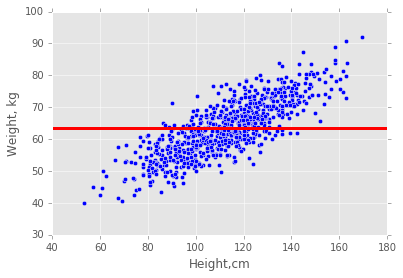

In [10]:
fig.clf()
ax = fig.add_subplot(111)
ax.set_xlabel("Height,cm")
ax.set_ylabel("Weight, kg")
ax.scatter(heights_train, weights_train)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [np.mean(weights_train), np.mean(weights_train)], linewidth=3, color="red")
ax.set_xlim([xmin, xmax])
fig

As you can see, such a model would perform poorly on estimating the weights of the tallest and shortest aliens, but for aliens that are average height (e.g., most of them) then guessing the average weight is not too far off. 

Here's a baseline. Guessing the mean is an unsophisticated model that requires only a single calculation. If our model does better than this, good. If not, then there's no reason not to use the mean as a model. 

One approach to making this comparison is to calculate the value of the *coefficient of determination*, also known as $R^2$. The value of $R^2$ is one minus the MSE of the model divided by the MSE of the mean. $R^2$ ranges from -1 to 1; higher is better. If $R^2$ equals 0, then your model is doing no better than the mean. If it is less than 0, it means your model does *worse* than the mean. If it greater than 0, your model is doing better than the mean. If $R^2$ is equal to 1, it means your model is perfect - so we'll never see this. 

What's the value of $R^2$ for our model? As usual, scikit learn has a method.

In [11]:
from sklearn.metrics import r2_score

Like the MSE function, ``r2_score`` takes the true values and the predicted values as its argument.

In [12]:
r2 = r2_score(weights_test, weights_predicted)
print(r2)

0.656153105061


With $R^2 = 0.66$, we know our model performs significantly better than guessing the average. It's not a value of 1, but as I said, no model is perfect so that's not the value we're expecting. 

# Evaluating Classifiers

We can calculate the MSE and R squared for the test set when we're making regression models. If we're making classification models, the approach is different. Remember, in regression we're predicting a number, in classification, we're predicting a class, a discrete variable, where each data point takes one of a finit set of values.

Let's re-make the k-NN classifier for the iris data, but this time we'll conduct a train-test split. We'll train on the train data and evaluate on the test data. I'll use a value of $k = 5$. 

In [13]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

Let's divide the data in to training and testing sets, using sklearn's handy method. I'm going to make the test size a little bigger: one third of the data we have. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
print(X_train.shape)
print(X_test.shape)

(100, 2)
(50, 2)


There are 100 instances in the training set and 50 instances in the test set. 

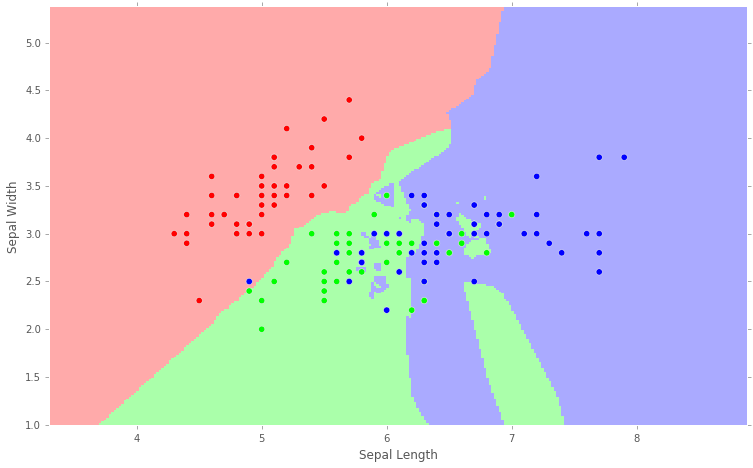

In [15]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

fig.clf()
ax = fig.add_subplot(111)
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold, s=40)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
fig.set_size_inches(12.5, 7.5)
fig

Using the classifier's ``predict`` method, let's see what labels the classifier would assign to the *unseen* test data. 

In [16]:
y_predicted = clf.predict(X_test)
y_predicted[:5]

array([0, 1, 0, 2, 0])

So we have some unseen test data, we have the labels that the classifier predicts for the test data, and we also have the true labels for the test data. How do we quantify how well the classifier performed? 

# Accuracy

There are 50 test examples. If we count how many the classifer got correct, and divide that number by 50, we have the percentage of the test examples the classifier got right. This is simply the accuracy of the classifer. As always, scikit learn has a method for this, and it takes the true labels and predicted labels as its arguments. 

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_predicted)
print(accuracy)

0.82


Accuracy is 0.82: it got 82% of the test data right. 41 out of 50. This is actually quite good. 

What is the baseline we can compare it to? Like with regression, we can imagine a "Dummy Classifier" that classifies according to a simple rule. In classification, imagine a dummy classifier that guesses entirely at random. Since there are 3 labels to choose from, we would expect a random dummy classifier to be right 1/3rd of the time, therefore getting an accuracy of 0.33. With an accuracy of 0.82, our classifier is much better than a random baseline of 0.33.

# Confusion Matrix

To get a better view of how the classifier is actually performing on the test data, we can look at something called the confusion matrix. Scikit-learn has a method for this. 

In [18]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_predicted))

[[20  0  0]
 [ 0 11  4]
 [ 1  4 10]]


We see here that the confusion matrix has 3 rows and 3 columns - 1 for each of the labels in the test set. In this instance, each of the rows and columns represent the iris species *I. setosa*, *I. versicolor*, and *I. virginica*, respectively. The rows represent the *true labels* and the columns represent the *predicted labels*. 

The value in row 1, column 1 is 20. This means that the classifier assigned the label *I. setosa* to 20 data points whose true label was *I. setosa*. The value in row 3, column 1 is 1. This means the classifier assigned the label *I. setosa* to one instance whose true label was *I. virginica*. 

The *diagonal* of the matrix represents the correct classifications. 20 flowers that were *I. setosa* were labeled *I. setosa*, 11 flowers that were *I. versicolor* were labeled *I. versicolor*, and 10 flowers that were *I. virginica* were labeled *I. virginica*. Anything off the diagonal are misclassifications. So, for example, 4 flowers that were *I. versicolor* were incorrectly given the label *I. virginica*. 

# Precision and Recall

Let's ignore the first two species - *I. setosa* and *I. versicolor* - and focus exclusively on the third species - *I. virginica*. As we can see in the confusion matrix, there were 15 instances of *I. virginica* in the test data - this is the sum of the third row. 

Of those 15, 1 was incorrectly classified as *I. setosa*, and 4 were incorrectly classified as *I. versicolor*. The remaining 10 were correctly classified. 

We can describe this better by introducing a new set of vocabulary that is useful in evaluation: true positives, false positives, true negatives, and false negatives.

A *true positive* in this situation is an item that was classified as *I. virginica* and the true label was *I. virginica*. 

A *false positive* is an item that was classified as *I. virginica* but the true label was *not* *I. virgnica*. 

A *true negative* is an item that was not classified as *I. virgnica*, and the true label was also not *I. virgnica*. 

A *false negative* is an item that was not classified as *I. virginica*, but the true label *was* *I. virgniica*. 

Obviously, the goal of any classifier is to maximize true positives and negatives and minimize false positives and negatives. 

For the class *I. virginica*, there are:

* 10 true positives
* 4 false positives
* 31 true negatives
* 5 false negatives

Using these values, we can calculate the classifier's *precision* and *recall* when it comes to classifying *I. virginica*. 

The formula for *precision* is:

$$\frac{\text{TP}}{\text{TP+FP}}$$


One way to describe this quantity in plain English is: of all the instances that the classifier labeled as *I. virgnica*, how many of them were *actually* *I. virgnica*?

The formula for *recall* is:

$$\frac{\text{TP}}{\text{TP}+\text{FN}}$$

To describe this in plain English: of all the instances that were *actually* *I. virginica*, how many of them were correctly labeled as *I. virginica*?

Precision and recall are often at odds. You usually have high precision and low recall, or the other way around. 

Imagine a very "careful" classifier. It only labels something as *I. virginica* only if it's super, super sure. Let's say it's only super sure of 2 of those instances, and labels them as such. It's possible that this classifier has **high precision**, because of the ones it labeled, both were right. But it probably also has **low recall**, because it missed many true instances of *I. virginica*.

Now imagine a very dumb classifier. It labels **everything** as *I. virginica*. This classifier has **high recall** - it correctly identified *every* instance of *I. virgnica* in the set. But it has **low precision** - of all the items it labeled *I. virginica*, many of them ar wrong. 

As always, scikit-learn has built-in methods for getting precision and recall. 

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Remember that precision and recall can be calculated *only with respect to a given label*. In the example above, we discussed recall and precision with respect to label 2, *I. virginica*. 

When we call these functions, it will return 3 values, the recall or precision with respect to *each label*. I'm providing a value of ``None`` to the parameter `average` to suppress some of the more complicated behavior this function can do. 

In [20]:
precision = precision_score(y_test, y_predicted, average=None)
print(precision)

[ 0.95238095  0.73333333  0.71428571]


In [21]:
recall = recall_score(y_test, y_predicted, average=None)
print(recall)

[ 1.          0.73333333  0.66666667]


Here, we can see that the classifier performed most poorly with the 3rd label, *I. virginica*. 

The precision was 0.71: of the instances that the classifier labeled *I. virginica*, only 71% of them were actually *I. virginica*. 

The recall was 0.67: of *all* the instances of *I. virginica*, it only correctly labeled 67% of them. 

# F1 Score

The F1 score is a metric that combines both precision and recall. As such, it's very frequently used as a way to evaluate classifiers. It's calculated as follows:

$$ F_1 = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$$

As usual, we can use scikit-learn:

In [22]:
from sklearn.metrics import f1_score

f1_score(y_test, y_predicted, average=None)

array([ 0.97560976,  0.73333333,  0.68965517])

This provides the F1 score for *each* category. Finally, to zero in on 1 single number to represent the quality of the classifier, we can get the *weighted average* of each of these F1 scores. It's *weighted* because in many situations you don't want to count the F1 scores equally, particularly since the distribution of labels may not be uniform.

In [23]:
f1_score(y_test, y_predicted, average="weighted")

0.81714045416316228

F1 scores range from 0 to 1. It turns out here that the F1 score I got was quite similar to the accuracy in general, but keep in mind that this isn't always the case. 

Much research published nowadays report F1 scores to demonstrate how effective their methods are, so I highly recommend using F1 scores on your final project if your developing a classifier. 